In [21]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

datadir = "/content/drive/My Drive/CS543"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


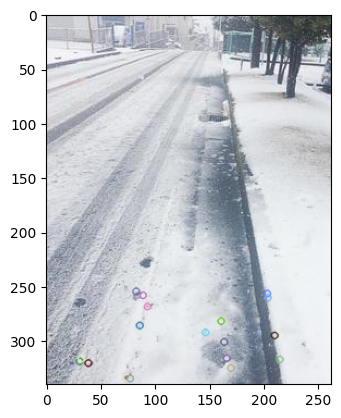

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read image
# just change your image directory here and it should work!
image = cv2.imread('/content/drive/MyDrive/CS543/challenge-area-1.png')
# image = cv2.imread('/content/drive/MyDrive/CS543/solidWhiteCurve.jpg')
image = cv2.imread('/content/drive/MyDrive/CS543/543snow.jpg')
# image = cv2.imread('/content/drive/MyDrive/CS543/543rain.jpg')

# turn to HSV
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# yellow and white hsv range
yellow_low = np.array([15, 100, 100])
yellow_high = np.array([35, 255, 255])
white_low = np.array([0, 0, 0])
white_high = np.array([360, 20, 255])

# yellow_low = np.array([0, 0, 0])
# yellow_high = np.array([360, 20, 255])
# white_low = np.array([0, 0, 0])
# white_high = np.array([360, 20, 255])

mask_yellow = cv2.inRange(image_hsv, yellow_low, yellow_high)
mask_white = cv2.inRange(image_hsv, white_low, white_high)
combined_mask = cv2.bitwise_or(mask_yellow, mask_white)

# Sift from mp3
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, mask=combined_mask)

# do work on only half image
half_keypoints = []
for i in range(len(keypoints)):
  if keypoints[i].pt[1]>image.shape[0]/2+50:
    half_keypoints.append(keypoints[i])
keypoints = half_keypoints

# work on keypoints by dividing into left and right side
key_left = []
key_right = []


# coordinates calc
for i in keypoints:
  coor = i.pt
  if(coor[0]<=image.shape[0]):
    if coor[0]/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=2:
      key_left.append(i)
  else:
    if -(coor[0]-image.shape[1]/2)/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=1:
      key_right.append(i)


# print(len(key_left))
# print(len(key_left))
key_left_fix = []
for i in key_left:
  if i.pt[0] <= 130:
    key_left_fix.append(i)
  else:
    key_right.append(i)
key_left = key_left_fix

# for i in key_left:
#   print(i.pt)
# show keypoint results
keypoint_image = cv2.drawKeypoints(image, key_left+key_right, None)
keypoint_image_rgb = cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(keypoint_image_rgb)
plt.show()


#turn to numpy array
points_left = []
points_right = []
for i in range(len(key_left)):
  points_left.append(key_left[i].pt)
for i in range(len(key_right)):
  points_right.append(key_right[i].pt)
points_left = np.array(points_left)
points_right = np.array(points_right)

# keypoints changes too
keypoints_array = np.zeros((len(keypoints), 2))
for i in range(len(keypoints)):
  keypoints_array[i] = keypoints[i].pt
keypoints = keypoints_array

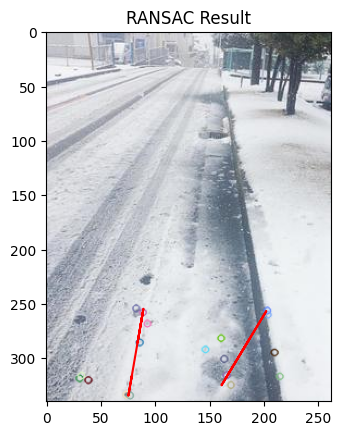

In [23]:
# only keep left and right keypoints
key_valid = key_left + key_right
key_valid_array = np.zeros((len(key_valid), 2))
for i in range(len(key_valid)):
  key_valid_array[i] = key_valid[i].pt
key_valid = key_valid_array

# use RANSAC to get line result
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

# handle left side
model_left = RANSACRegressor()
model_left.fit(points_left[:, 1].reshape(-1, 1), points_left[:, 0])

# handle right side
model_right = RANSACRegressor()
model_right.fit(points_right[:, 1].reshape(-1, 1), points_right[:, 0])

# lines
# only predict on the lower half of the image
left_line_x = points_left[:, 1]
left_line_y = model_left.predict(left_line_x.reshape(-1, 1))
right_line_x = points_right[:, 1]
right_line_y = model_right.predict(right_line_x.reshape(-1, 1))

# results

# keep only results from bottom to half of picture(horizon)
left_line_y_fixed = []
left_line_x_fixed = []
right_line_y_fixed = []
right_line_x_fixed = []

for i in range(len(left_line_y)):
  if(left_line_x[i]<=image.shape[0]):
    left_line_y_fixed.append(left_line_y[i])
    left_line_x_fixed.append(left_line_x[i])
  else:
    break

for i in range(len(right_line_y)):
  if(right_line_x[i]<=image.shape[0]):
    right_line_y_fixed.append(right_line_y[i])
    right_line_x_fixed.append(right_line_x[i])
  else:
    break

# final result
plt.figure()
plt.plot(left_line_y_fixed, left_line_x_fixed, color='red')
plt.plot(right_line_y_fixed, right_line_x_fixed, color='red')
plt.imshow(keypoint_image_rgb)

plt.title('RANSAC Result')
plt.show()

In [ ]:
# use polynomial to get curve result

import numpy as np
import matplotlib.pyplot as plt


# degree 2 gives curve
degree = 2
left_coef = np.polyfit(points_left[:, 1], points_left[:, 0], degree)
right_coef = np.polyfit(points_right[:, 1], points_right[:, 0], degree)

# get polyclass for both lines
left_polynomial = np.poly1d(left_coef)
right_polynomial = np.poly1d(right_coef)

# get y values
left_y = left_polynomial(points_left[:, 1])
right_y = right_polynomial(points_right[:, 1])

# plot result
plt.plot(left_y, points_left[:, 1], color='red')
plt.plot(right_y, points_right[:, 1], color='red')
plt.imshow(keypoint_image_rgb)
plt.title('Polynomial Fitting Result')
plt.show()

In [25]:
# read mp4 and detect
import cv2
import os

# Define the video path
video_path = '/content/drive/MyDrive/CS543/543video.mp4'

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Open video file
video_capture = cv2.VideoCapture(video_path)
flag = 0
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    else:
      frame_filename = os.path.join(output_dir, f'frame_{flag:04d}.jpg')
      cv2.imwrite(frame_filename, frame)
      flag += 1
video_capture.release()

In [26]:
# plt.figure()
# plt.plot(left_y, points_left[:, 1], color='red')
# plt.plot(right_y, points_right[:, 1], color='red')
# plt.axis("off")
# plt.imshow(keypoint_image_rgb)
# plt.savefig("polytest.png")

In [ ]:
import time
start_time = time.time()
end_time = time.time()
total_time_all = end_time - start_time
folder_path = '/content/frames'
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
flag = -1
for img_file in image_files:
  start_time = time.time()
  flag = flag + 1
  image_path = folder_path + '/' + img_file
  image = cv2.imread(image_path)
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  yellow_low = np.array([0, 0, 0])
  yellow_high = np.array([360, 20, 255])
  white_low = np.array([0, 0, 0])
  white_high = np.array([360, 20, 255])

  mask_yellow = cv2.inRange(image_hsv, yellow_low, yellow_high)
  mask_white = cv2.inRange(image_hsv, white_low, white_high)
  combined_mask = cv2.bitwise_or(mask_yellow, mask_white)

  # Sift from mp3
  sift = cv2.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(image, mask=combined_mask)

  # do work on only half image
  half_keypoints = []
  for i in range(len(keypoints)):
    if keypoints[i].pt[1]>image.shape[0]/2+50:
      half_keypoints.append(keypoints[i])
  keypoints = half_keypoints

  # work on keypoints by dividing into left and right side
  key_left = []
  key_right = []


  # coordinates calc
  for i in keypoints:
    coor = i.pt
    if(coor[0]<=image.shape[0]):
      if coor[0]/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=2:
        key_left.append(i)
    else:
      if -(coor[0]-image.shape[1]/2)/(image.shape[1]/2) + coor[1]/(image.shape[0]/2)>=1:
        key_right.append(i)

  # for i in key_left:
  #   print(i.pt)
  # show keypoint results
  keypoint_image = cv2.drawKeypoints(image, key_left+key_right, None)
  keypoint_image_rgb = cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(keypoint_image_rgb)
  plt.show()


  #turn to numpy array
  points_left = []
  points_right = []
  for i in range(len(key_left)):
    points_left.append(key_left[i].pt)
  for i in range(len(key_right)):
    points_right.append(key_right[i].pt)
  points_left = np.array(points_left)
  points_right = np.array(points_right)

  # keypoints changes too
  keypoints_array = np.zeros((len(keypoints), 2))
  for i in range(len(keypoints)):
    keypoints_array[i] = keypoints[i].pt
  keypoints = keypoints_array

  # only keep left and right keypoints
  key_valid = key_left + key_right
  key_valid_array = np.zeros((len(key_valid), 2))
  for i in range(len(key_valid)):
    key_valid_array[i] = key_valid[i].pt
  key_valid = key_valid_array

  # use RANSAC to get line result
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.linear_model import RANSACRegressor

  # handle left side
  model_left = RANSACRegressor()
  model_left.fit(points_left[:, 1].reshape(-1, 1), points_left[:, 0])

  # handle right side
  model_right = RANSACRegressor()
  model_right.fit(points_right[:, 1].reshape(-1, 1), points_right[:, 0])

  # lines
  # only predict on the lower half of the image
  left_line_x = points_left[:, 1]
  left_line_y = model_left.predict(left_line_x.reshape(-1, 1))
  right_line_x = points_right[:, 1]
  right_line_y = model_right.predict(right_line_x.reshape(-1, 1))

  # results

  # keep only results from bottom to half of picture(horizon)
  left_line_y_fixed = []
  left_line_x_fixed = []
  right_line_y_fixed = []
  right_line_x_fixed = []

  for i in range(len(left_line_y)):
    if(left_line_x[i]<=image.shape[0]):
      left_line_y_fixed.append(left_line_y[i])
      left_line_x_fixed.append(left_line_x[i])
    else:
      break

  for i in range(len(right_line_y)):
    if(right_line_x[i]<=image.shape[0]):
      right_line_y_fixed.append(right_line_y[i])
      right_line_x_fixed.append(right_line_x[i])
    else:
      break

  # final result
  # plt.figure()
  # plt.plot(left_line_y_fixed, left_line_x_fixed, color='red')
  # plt.plot(right_line_y_fixed, right_line_x_fixed, color='red')
  # plt.imshow(keypoint_image_rgb)

  # plt.title('RANSAC Result')
  # plt.show()


  # degree 2 gives curve
  degree = 2
  left_coef = np.polyfit(points_left[:, 1], points_left[:, 0], degree)
  right_coef = np.polyfit(points_right[:, 1], points_right[:, 0], degree)

  # get polyclass for both lines
  left_polynomial = np.poly1d(left_coef)
  right_polynomial = np.poly1d(right_coef)

  # get y values
  left_y = left_polynomial(points_left[:, 1])
  right_y = right_polynomial(points_right[:, 1])

  # plot result
  plt.figure()
  plt.plot(left_y, points_left[:, 1], color='red')
  plt.plot(right_y, points_right[:, 1], color='red')
  plt.axis("off")
  plt.imshow(keypoint_image_rgb)
  # save_path = "/content/drive/MyDrive/CS543/frame_out/frame_" + str(flag) + ".jpg"
  end_time = time.time()
  total_time = end_time - start_time
  total_time_all = total_time_all + total_time
  save_path = "/content/drive/MyDrive/CS543/frame_poly/" + str(img_file)
  plt.savefig(save_path)


print("time is " + str(total_time_all))

In [ ]:
import cv2
import os

# paths
frames_folder_path = '/content/drive/MyDrive/CS543/frame_poly'
output_video_path = 'poly_detection.mp4'

# Get a sorted list of image file names
frame_files = sorted([f for f in os.listdir(frames_folder_path) if f.endswith('.jpg')])

frame_0 = os.path.join(frames_folder_path, frame_files[0])
frame = cv2.imread(frame_0)

type_mp4 = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video_path, type_mp4, 30, (frame.shape[1], frame.shape[0]))

# loop through frames
for current_frame in frame_files:
    frame_path = os.path.join(frames_folder_path, current_frame)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

In [ ]:
print(left_coef)
print(right_coef)

[ 1.68980529e-03 -1.73772920e+00  7.50574089e+02]
[ 1.98814065e-02 -1.49446281e+01  3.35335987e+03]
